### Model description and features
XGB model on all users that added product on July 2016,  

Features:
--------
* March April May June 2015, user attributes
* July 2015, user attributes
* March to June 2015, product subscription information

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from scripts.kaggle.helpers import make_submission
import datetime
from tqdm import tqdm
import gc
import itertools
from multiprocessing import Pool
import pickle

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

%pylab inline
pylab.rcParams['figure.figsize'] = (12, 16)

%load_ext autotime

Populating the interactive namespace from numpy and matplotlib


In [2]:
TRAIN_MONTH_OLD_4 = '2015_02_28'
TRAIN_MONTH_OLD_3 = '2015_03_28'
TRAIN_MONTH_OLD_2 = '2015_04_28'
TRAIN_MONTH_OLD_1 = '2015_05_28'
TRAIN_MONTH_NEW = '2015_06_28'

TEST_MONTH_OLD_4 = '2016_02_28'
TEST_MONTH_OLD_3 = '2016_03_28'
TEST_MONTH_OLD_2 = '2016_04_28'
TEST_MONTH_OLD_1 = '2016_05_28'
#TEST_MONTH_NEW = '2016_06_28'

TRAIN_FILE_OLD_4 = 'data/train_' + TRAIN_MONTH_OLD_4 + '.csv'
TRAIN_FILE_OLD_3 = 'data/train_' + TRAIN_MONTH_OLD_3 + '.csv'
TRAIN_FILE_OLD_2 = 'data/train_' + TRAIN_MONTH_OLD_2 + '.csv'
TRAIN_FILE_OLD_1 = 'data/train_' + TRAIN_MONTH_OLD_1 + '.csv'
TRAIN_FILE_NEW = 'data/train_' + TRAIN_MONTH_NEW + '.csv'

ADDED_PRODUCTS_FILE = 'data/added_product_' + TRAIN_MONTH_OLD_1 + '.csv'

TEST_FILE_OLD_4 = 'data/train_' + TEST_MONTH_OLD_4 + '.csv'
TEST_FILE_OLD_3 = 'data/train_' + TEST_MONTH_OLD_3 + '.csv'
TEST_FILE_OLD_2 = 'data/train_' + TEST_MONTH_OLD_2 + '.csv'
TEST_FILE_OLD_1 = 'data/train_' + TEST_MONTH_OLD_1 + '.csv'
TEST_FILE_NEW = 'data/test_ver2.csv'

HEADER = ["fecha_dato", "ncodpers", "ind_empleado",
          "pais_residencia", "sexo", "age", "fecha_alta",
          "ind_nuevo", "antiguedad", "indrel", "ult_fec_cli_1t",
          "indrel_1mes", "tiprel_1mes", "indresi", "indext",
          "conyuemp", "canal_entrada", "indfall", "tipodom",
          "cod_prov", "nomprov", "ind_actividad_cliente",
          "renta", "segmento", "ind_ahor_fin_ult1",
          "ind_aval_fin_ult1", "ind_cco_fin_ult1",
          "ind_cder_fin_ult1", "ind_cno_fin_ult1",
          "ind_ctju_fin_ult1", "ind_ctma_fin_ult1",
          "ind_ctop_fin_ult1", "ind_ctpp_fin_ult1",
          "ind_deco_fin_ult1", "ind_deme_fin_ult1",
          "ind_dela_fin_ult1", "ind_ecue_fin_ult1",
          "ind_fond_fin_ult1", "ind_hip_fin_ult1",
          "ind_plan_fin_ult1", "ind_pres_fin_ult1",
          "ind_reca_fin_ult1", "ind_tjcr_fin_ult1",
          "ind_valo_fin_ult1", "ind_viv_fin_ult1",
          "ind_nomina_ult1", "ind_nom_pens_ult1",
          "ind_recibo_ult1"]

time: 18.7 ms


In [3]:
train_old_4 = pd.read_csv(TRAIN_FILE_OLD_4, header=None, names=HEADER)
train_old_3 = pd.read_csv(TRAIN_FILE_OLD_3, header=None, names=HEADER)
train_old_2 = pd.read_csv(TRAIN_FILE_OLD_2, header=None, names=HEADER)
train_old_1 = pd.read_csv(TRAIN_FILE_OLD_1, header=None, names=HEADER)
train_new = pd.read_csv(TRAIN_FILE_NEW, header=None, names=HEADER)

test_old_4 = pd.read_csv(TEST_FILE_OLD_4, header=None, names=HEADER)
test_old_3 = pd.read_csv(TEST_FILE_OLD_3, header=None, names=HEADER)
test_old_2 = pd.read_csv(TEST_FILE_OLD_2, header=None, names=HEADER)
test_old_1 = pd.read_csv(TEST_FILE_OLD_1, header=None, names=HEADER)
test_new = pd.read_csv(TEST_FILE_NEW)

added_products = pd.read_csv(ADDED_PRODUCTS_FILE)

/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2705: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2705: DtypeWarning: Columns (11,12,15,16,23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2705: DtypeWarning: Columns (11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


time: 51.9 s


In [4]:
for col in HEADER[24:]:
    test_new[col] = [0]*test_new.shape[0]

time: 3.37 s


In [5]:
combined = pd.concat((train_old_4, train_old_3, train_old_2, train_old_1,train_new,
                      test_old_4, test_old_3, test_old_2, test_old_1, test_new)).reset_index(drop=True)
del train_old_4, train_old_3, train_old_2, train_old_1, train_new,\
    test_old_4, test_old_3, test_old_2, test_old_1, test_new

time: 43.2 s


In [6]:
gc.collect()

63

time: 408 ms


In [7]:
def process_data_from_original_dataframe(combined, encoders=None):
    # fixing age
    combined['age'] = pd.to_numeric(combined['age'], errors='coerce')

    combined.loc[combined.age < 18, "age"] = \
        combined.loc[(combined.age > 18) &
                     (combined.age <= 30), "age"].mean(skipna=True)
    combined.loc[combined.age > 100, "age"] = \
        combined.loc[(combined.age > 30) &
                     (combined.age <= 100), "age"].mean(skipna=True)
    combined['age'].fillna(combined['age'].mean(), inplace=True)
    combined['age'] = combined['age'].astype(int)

    # fix ind_nuevo..
    combined.loc[combined.ind_nuevo.isnull(), 'ind_nuevo'] = 1

    # fix antiguedad
    combined['antiguedad'] = pd.to_numeric(combined['antiguedad'],
                                           errors='coerce')
    combined.loc[combined.antiguedad.isnull(), 'antiguedad'] = \
        combined.antiguedad.min()
    combined.loc[combined.antiguedad < 0, 'antiguedad'] = 0

    # fix indrel
    combined.loc[combined.indrel.isnull(), 'indrel'] = 1

    # drop useless cols
    combined.drop(['tipodom', 'cod_prov'], axis=1, inplace=True)

    # fix ind_actividad_cliente
    combined.loc[combined.ind_actividad_cliente.isnull(),
                 "ind_actividad_cliente"] = \
        combined.ind_actividad_cliente.median()

    # fix city name
    combined.loc[combined.nomprov ==
                 "CORU\xc3\x91A, A", "nomprov"] = "CORUNA, A"
    combined.loc[combined.nomprov.isnull(), 'nomprov'] = 'UNKNOWN'

    # fix incomes
    # combined.renta = pd.to_numeric(combined.renta, errors='coerce')
    combined['renta'] = pd.to_numeric(combined['renta'], errors='coerce')

    grouped = combined.groupby('nomprov').\
        agg({'renta': lambda x: x.median(skipna=True)}).reset_index()
    new_incomes = pd.merge(combined, grouped,
                           how='inner',
                           on='nomprov').loc[:, ['nomprov', 'renta_y']]

    new_incomes = new_incomes.\
        rename(columns={"renta_y": "renta"}).\
        sort_values("renta").sort_values("nomprov")

    combined.sort_values("nomprov", inplace=True)
    combined = combined.reset_index()
    new_incomes = new_incomes.reset_index()
    combined.loc[combined.renta.isnull(), "renta"] = \
        new_incomes.loc[combined.renta.isnull(), "renta"].median()
    combined.sort_values(by='fecha_dato', inplace=True)

    # rest of the columns
    string_data = combined.select_dtypes(include=["object"])
    missing_columns = [col for col in string_data
                       if string_data[col].isnull().any()]
    del string_data

    combined.loc[combined.indfall.isnull(), 'indfall'] = 'N'
    combined.loc[combined.tiprel_1mes.isnull(), 'tiprel_1mes'] = 'A'
    combined.tiprel_1mes = combined.tiprel_1mes.astype('category')

    map_dict = {
        '1.0': '1',
        '1': '1',
        '3.0': '3',
        'P': 'P',
        3.0: '3',
        2.0: '2',
        '3': '3',
        '2.0': '2',
        '4.0': '4',
        '4': '4',
        '2': '2',
        1.0: '1',
        4.0: '4'
    }

    combined.indrel_1mes.fillna('P', inplace=True)
    combined.indrel_1mes = combined.indrel_1mes.apply(lambda x: map_dict[x])
    combined.indrel_1mes = combined.indrel_1mes.astype('category')

    unknown_cols = [col for col in missing_columns if
                    col not in ['indfall', 'tiprel_1mes', 'indrel_1mes']]
    for col in unknown_cols:
        combined.loc[combined[col].isnull(), col] = "UNKNOWN"

    # feature cols
    feature_cols = combined.iloc[:1, ].filter(regex="ind_+.*ult.*").\
        columns.values
    for col in feature_cols:
        combined.loc[combined[col].isnull(), col] = 0
        combined[col] = combined[col].astype(int)

    del combined['ult_fec_cli_1t'], combined['fecha_alta']
    encoder_cols = ['sexo', 'indrel_1mes', 'pais_residencia', 'ind_empleado',
                'segmento', 'tiprel_1mes', 'indresi', 'indext', 'conyuemp',
                'canal_entrada', 'indfall', 'nomprov']
    if encoders == None:
        encoders = []
        for col in encoder_cols:
            temp_enc = LabelEncoder()
            temp_enc.fit(combined[col])
            combined[col] = temp_enc.transform(combined[col])
            encoders.append(temp_enc)
    else:
        for i in range(len(encoders)):
            combined[encoder_cols[i]] = encoders[i].transform(combined[encoder_cols[i]])
        
    return combined, encoders



time: 236 ms


In [8]:
combined, encoders = process_data_from_original_dataframe(combined)

time: 6min 27s


In [9]:
train_old_4 = combined.loc[combined.fecha_dato == '2015-02-28', :].reset_index(drop=True)
train_old_3 = combined.loc[combined.fecha_dato == '2015-03-28', :].reset_index(drop=True)
train_old_2 = combined.loc[combined.fecha_dato == '2015-04-28', :].reset_index(drop=True)
train_old_1 = combined.loc[combined.fecha_dato == '2015-05-28', :].reset_index(drop=True)
train_new = combined.loc[combined.fecha_dato == '2015-06-28', :].reset_index(drop=True)

test_old_4 = combined.loc[combined.fecha_dato == '2016-02-28', :].reset_index(drop=True)
test_old_3 = combined.loc[combined.fecha_dato == '2016-03-28', :].reset_index(drop=True)
test_old_2 = combined.loc[combined.fecha_dato == '2016-04-28', :].reset_index(drop=True)
test_old_1 = combined.loc[combined.fecha_dato == '2016-05-28', :].reset_index(drop=True)
test_new = combined.loc[combined.fecha_dato == '2016-06-28', :].reset_index(drop=True)
del combined
gc.collect()

136

time: 31.8 s


In [10]:
del train_old_1['index'], train_old_2['index'], train_old_3['index'], train_old_4['index'], train_new['index'], test_old_1['index'], test_old_2['index'], test_old_3['index'], test_old_4['index'], test_new['index']
del train_old_1['fecha_dato'], train_old_2['fecha_dato'], train_old_3['fecha_dato'], train_old_4['fecha_dato'], train_new['fecha_dato'], test_old_1['fecha_dato'], test_old_2['fecha_dato'], test_old_3['fecha_dato'], test_old_4['fecha_dato'], test_new['fecha_dato']

time: 4.21 s


In [12]:
for df in train_old_4, train_old_3, train_old_2, train_old_1, train_new, test_old_4, test_old_3, test_old_2, test_old_1, test_new:
    print df.shape

(627394, 43)
(629209, 43)
(630367, 43)
(631957, 43)
(632110, 43)
(920904, 43)
(925076, 43)
(928274, 43)
(931453, 43)
(929615, 43)


In [11]:
train_old_4.set_index('ncodpers', inplace=True)
train_old_3.set_index('ncodpers', inplace=True)
train_old_2.set_index('ncodpers', inplace=True)
train_old_1.set_index('ncodpers', inplace=True)
train_new.set_index('ncodpers', inplace=True)

test_old_4.set_index('ncodpers', inplace=True)
test_old_3.set_index('ncodpers', inplace=True)
test_old_2.set_index('ncodpers', inplace=True)
test_old_1.set_index('ncodpers', inplace=True)
test_new.set_index('ncodpers', inplace=True)

time: 4.38 s


## Features
* What products got added in the last 4 months
* What products got removed in the last 4 months
* What products were there the whole period
* What products were there for only partial period
* What products the last month doesn't have when compared to the product history
* Identify the user attributes to keep track of similar to above product history
* Total number of products

In [12]:
added_products.set_index('ncodpers', inplace=True)
print added_products.shape

(41745, 1)
time: 5.11 ms


In [13]:
train = pd.DataFrame()
train['ncodpers'] = added_products.index
train.set_index('ncodpers', inplace=True)

test = pd.DataFrame()
test['ncodpers'] = test_new.index
test.set_index('ncodpers', inplace=True)

for col in train_new.columns[:18]:
    train['current_' + col] = train_new.loc[added_products.index, col]
    test['current_' + col] = test_new.loc[test_new.index, col]
    
for col in HEADER[24:]:
    train['current_' + col] = train_old_1.loc[added_products.index, col]
    test['current_' + col] = test_old_1.loc[test_new.index, col]
    


time: 15.9 s


In [14]:
def get_all_past_values_of_col(ind, col, old_dfs):
    """
    old dfs must go from current to old months
    """
    values = []
    temp = None
    for df in old_dfs:
        try:
            value = df.ix[ind, col]
            values.append(value)
            temp = value
        except KeyError:
            values.append(value)
    return values

time: 25.1 ms


In [15]:
def is_producted_added_in_past(past_values):
    """
    products go from current month to older months
    """
    current = past_values[0]
    is_added = False
    for v in past_values[1:]:
        is_added = (current ^ v) & current
        current = v
        if is_added:
            return is_added
    return is_added

def is_product_removed_in_past(past_values):
    return is_producted_added_in_past(list(reversed(past_values)))

time: 7.56 ms


In [16]:
def get_product_features(past_values):
    """
    takes in values from current month to old months and computes various features
    product_exists_atleast_once, product_exists_in_all_months, product_doesnt_exist_in_all_months
    product_removed_in_the_past, product_added_in_the_past
    """
    product_exists_atleast_once = any(past_values)
    product_exists_in_all_months = all(past_values)
    product_doesnt_exist_in_all_months = all([not x for x in past_values])
    product_removed_in_the_past = is_product_removed_in_past(past_values)
    product_added_in_the_past = is_producted_added_in_past(past_values)
    return product_exists_atleast_once, product_exists_in_all_months, product_doesnt_exist_in_all_months, product_removed_in_the_past, product_added_in_the_past

time: 25 ms


In [67]:
# get_product_features(741176, HEADER[26])
def fill_product_features_from_history(df, *args):
    for i in tqdm(df.index):
        for col in HEADER[24:]:
            past_values = get_all_past_values_of_col(i, col, args)
            product_features = get_product_features(past_values)
            df.set_value(i, 'pf1_exists_at_least_1_' + col, product_features[0])
            df.set_value(i, 'pf2_exists_all_months_' + col, product_features[1])
            df.set_value(i, 'pf3_doesnt_exist_at_all_' + col, product_features[2])
            df.set_value(i, 'pf4_product_removed_recently_' + col, product_features[3])
            df.set_value(i, 'pf5_product_added_recently_' + col, product_features[4])

time: 7.71 ms


In [18]:
fill_product_features_from_history(train, train_old_1, train_old_2, train_old_3, train_old_4)

100%|██████████| 41745/41745 [02:28<00:00, 138.58it/s]

time: 2min 28s


In [112]:
fill_product_features_from_history(test, test_old_1, test_old_2, test_old_3, test_old_4)

100%|██████████| 929615/929615 [39:00<00:00, 397.15it/s]

time: 39min


# lag features related to user attributes, not really used, for further inspection in future notebooks

In [158]:
def is_col_changed_in_past(past_values):
    """
    products go from current month to older months
    """
    current = past_values[0]
    is_changed = False
    for v in past_values[1:]:
        is_changed = current != v
        current = v
        if is_changed:
            return is_changed
    return is_changed

time: 3.75 ms


In [164]:
is_col_changed_in_past([1,1,0,1])

True

time: 3.36 ms


In [169]:
changed = pd.DataFrame()
changed['ncodpers'] = test_new.index
changed.set_index('ncodpers', inplace=True)
for i in tqdm(test_new.index):
    for col in train_old_1.columns[:18]:
        past_values = get_all_past_values_of_col(i, col, [test_old_1, test_old_2, test_old_3, test_old_4])
        is_changed = is_col_changed_in_past(past_values)
        changed.set_value(i, 'is_changed_' + col, is_changed)
    

100%|██████████| 929615/929615 [15:11<00:00, 1020.04it/s]

time: 15min 11s


In [170]:
for col in changed.columns:
    print changed[col].value_counts()

False    929615
Name: is_changed_ind_empleado, dtype: int64
False    929576
True         39
Name: is_changed_pais_residencia, dtype: int64
False    929606
True          9
Name: is_changed_sexo, dtype: int64
False    685029
True     244586
Name: is_changed_age, dtype: int64
False    865799
True      63816
Name: is_changed_ind_nuevo, dtype: int64
True     925251
False      4364
Name: is_changed_antiguedad, dtype: int64
False    929529
True         86
Name: is_changed_indrel, dtype: int64
False    915490
True      14125
Name: is_changed_indrel_1mes, dtype: int64
False    894211
True      35404
Name: is_changed_tiprel_1mes, dtype: int64
False    929577
True         38
Name: is_changed_indresi, dtype: int64
False    929516
True         99
Name: is_changed_indext, dtype: int64
False    929563
True         52
Name: is_changed_conyuemp, dtype: int64
False    914083
True      15532
Name: is_changed_canal_entrada, dtype: int64
False    929470
True        145
Name: is_changed_indfall, dtype: int6

In [173]:
for col in test_old_1.columns:
    print col, get_all_past_values_of_col(1533309, col, [test_old_1, test_old_2, test_old_3, test_old_4])

ind_empleado [3, 3, 3, 3]
pais_residencia [36, 36, 36, 36]
sexo [0, 0, 0, 0]
age [52, 52, 52, 52]
ind_nuevo [1.0, 1.0, 1.0, 1.0]
antiguedad [3.0, 2.0, 1.0, 0.0]
indrel [1.0, 1.0, 1.0, 1.0]
indrel_1mes [0, 0, 0, 4]
tiprel_1mes [1, 0, 0, 0]
indresi [1, 1, 1, 1]
indext [0, 0, 0, 0]
conyuemp [2, 2, 2, 2]
canal_entrada [155, 155, 155, 162]
indfall [0, 0, 0, 0]
nomprov [14, 14, 14, 14]
ind_actividad_cliente [1.0, 1.0, 1.0, 0.0]
renta [95184.839999999997, 95184.839999999997, 95184.839999999997, 95184.839999999997]
segmento [1, 1, 1, 3]
ind_ahor_fin_ult1 [0, 0, 0, 0]
ind_aval_fin_ult1 [0, 0, 0, 0]
ind_cco_fin_ult1 [1, 1, 1, 0]
ind_cder_fin_ult1 [0, 0, 0, 0]
ind_cno_fin_ult1 [0, 0, 0, 0]
ind_ctju_fin_ult1 [0, 0, 0, 0]
ind_ctma_fin_ult1 [0, 0, 0, 0]
ind_ctop_fin_ult1 [0, 0, 0, 0]
ind_ctpp_fin_ult1 [0, 0, 0, 0]
ind_deco_fin_ult1 [0, 0, 0, 0]
ind_deme_fin_ult1 [0, 0, 0, 0]
ind_dela_fin_ult1 [0, 0, 0, 0]
ind_ecue_fin_ult1 [0, 0, 0, 0]
ind_fond_fin_ult1 [0, 0, 0, 0]
ind_hip_fin_ult1 [0, 0, 0, 0]
ind

In [171]:
changed.loc[changed.is_changed_segmento,:].head()

,is_changed_ind_empleado,is_changed_pais_residencia,is_changed_sexo,is_changed_age,is_changed_ind_nuevo,is_changed_antiguedad,is_changed_indrel,is_changed_indrel_1mes,is_changed_tiprel_1mes,is_changed_indresi,is_changed_indext,is_changed_conyuemp,is_changed_canal_entrada,is_changed_indfall,is_changed_nomprov,is_changed_ind_actividad_cliente,is_changed_renta,is_changed_segmento
ncodpers,,,,,,,,,,,,,,,,,,
1533309,False,False,False,False,False,True,False,True,True,False,False,False,True,False,False,True,False,True
1539700,False,False,False,True,False,True,False,True,False,False,False,False,True,False,False,False,False,True
1333325,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True
1531232,False,False,False,True,False,True,False,True,False,False,False,False,False,False,False,False,False,True
1239851,False,False,False,False,False,True,False,True,True,False,False,False,True,False,False,False,False,True


time: 747 ms


# Not just June 2015 data for training, include all the training samples

In [19]:
def get_file_string_from_train_data(train_data):
    date_time = datetime.datetime(train_data[0], train_data[1], 28)
    return '_'.join(str(date_time.date()).split('-'))

def get_date_string_from_train_data(train_data):
    date_time = datetime.datetime(train_data[0], train_data[1], 28)
    return '-'.join(str(date_time.date()).split('-'))

def subtract_one_month(train_data):
    if train_data[1] == 1:
        return 2015, 12
    else:
        return train_data[0], train_data[1] - 1
    
som = subtract_one_month

time: 12.2 ms


In [56]:
print som((2016, 1))
print som(som((2016, 2)))

(2015, 12)
(2015, 12)
time: 1.2 ms


In [178]:
get_file_string_from_train_data(som(som((2015,6))))

'2015_04_28'

time: 3.22 ms


In [20]:
TRAIN_DATA = 2015, 7

TRAIN_MONTH_OLD_4 = get_file_string_from_train_data(som(som(som(som(TRAIN_DATA)))))
TRAIN_MONTH_OLD_3 = get_file_string_from_train_data(som(som(som(TRAIN_DATA))))
TRAIN_MONTH_OLD_2 = get_file_string_from_train_data(som(som(TRAIN_DATA)))
TRAIN_MONTH_OLD_1 = get_file_string_from_train_data(som(TRAIN_DATA))
TRAIN_MONTH_NEW = get_file_string_from_train_data(TRAIN_DATA)


TRAIN_FILE_OLD_4 = 'data/train_' + TRAIN_MONTH_OLD_4 + '.csv'
TRAIN_FILE_OLD_3 = 'data/train_' + TRAIN_MONTH_OLD_3 + '.csv'
TRAIN_FILE_OLD_2 = 'data/train_' + TRAIN_MONTH_OLD_2 + '.csv'
TRAIN_FILE_OLD_1 = 'data/train_' + TRAIN_MONTH_OLD_1 + '.csv'
TRAIN_FILE_NEW = 'data/train_' + TRAIN_MONTH_NEW + '.csv'

ADDED_PRODUCTS_FILE = 'data/added_product_' + TRAIN_MONTH_OLD_1 + '.csv'


time: 7.85 ms


In [21]:
print TRAIN_FILE_NEW
print TRAIN_FILE_OLD_1
print TRAIN_FILE_OLD_2
print TRAIN_FILE_OLD_3
print TRAIN_FILE_OLD_4
print ADDED_PRODUCTS_FILE

data/train_2015_07_28.csv
data/train_2015_06_28.csv
data/train_2015_05_28.csv
data/train_2015_04_28.csv
data/train_2015_03_28.csv
data/added_product_2015_06_28.csv
time: 2.23 ms


In [22]:
train_old_4 = pd.read_csv(TRAIN_FILE_OLD_4, header=None, names=HEADER)
train_old_3 = pd.read_csv(TRAIN_FILE_OLD_3, header=None, names=HEADER)
train_old_2 = pd.read_csv(TRAIN_FILE_OLD_2, header=None, names=HEADER)
train_old_1 = pd.read_csv(TRAIN_FILE_OLD_1, header=None, names=HEADER)
train_new = pd.read_csv(TRAIN_FILE_NEW, header=None, names=HEADER)

added_products_temp = pd.read_csv(ADDED_PRODUCTS_FILE)

time: 22.4 s


In [23]:
combined = pd.concat((train_old_4, train_old_3, train_old_2, train_old_1,train_new)).reset_index(drop=True)
del train_old_4, train_old_3, train_old_2, train_old_1, train_new
gc.collect()

combined, encoders = process_data_from_original_dataframe(combined, encoders)

time: 1min 53s


In [24]:
train_old_4 = combined.loc[combined.fecha_dato == '-'.join(TRAIN_MONTH_OLD_4.split('_')), :].reset_index(drop=True)
train_old_3 = combined.loc[combined.fecha_dato == '-'.join(TRAIN_MONTH_OLD_3.split('_')), :].reset_index(drop=True)
train_old_2 = combined.loc[combined.fecha_dato == '-'.join(TRAIN_MONTH_OLD_2.split('_')), :].reset_index(drop=True)
train_old_1 = combined.loc[combined.fecha_dato == '-'.join(TRAIN_MONTH_OLD_1.split('_')), :].reset_index(drop=True)
train_new = combined.loc[combined.fecha_dato == '-'.join(TRAIN_MONTH_NEW.split('_')), :].reset_index(drop=True)


time: 9.27 s


In [25]:
del train_old_1['index'], train_old_2['index'], train_old_3['index'], train_old_4['index'], train_new['index']
del train_old_1['fecha_dato'], train_old_2['fecha_dato'], train_old_3['fecha_dato'], train_old_4['fecha_dato'], train_new['fecha_dato']

time: 1.39 s


In [26]:
for df in train_old_1, train_old_2, train_old_3, train_old_4, train_new:
    print df.shape

(632110, 43)
(631957, 43)
(630367, 43)
(629209, 43)
(829817, 43)
time: 6.48 ms


In [27]:
train_old_4.set_index('ncodpers', inplace=True)
train_old_3.set_index('ncodpers', inplace=True)
train_old_2.set_index('ncodpers', inplace=True)
train_old_1.set_index('ncodpers', inplace=True)
train_new.set_index('ncodpers', inplace=True)

added_products_temp.set_index('ncodpers', inplace=True)

time: 1.9 s


In [30]:
train_temp = pd.DataFrame()
train_temp['ncodpers'] = added_products_temp.index
train_temp.set_index('ncodpers', inplace=True)


for col in train_new.columns[:18]:
    train_temp['current_' + col] = train_new.loc[added_products_temp.index, col]
    
for col in HEADER[24:]:
    train_temp['current_' + col] = train_old_1.loc[added_products_temp.index, col]

time: 6.58 s


In [31]:
fill_product_features_from_history(train_temp, train_old_1, train_old_2, train_old_3, train_old_4)

100%|██████████| 33362/33362 [01:56<00:00, 285.47it/s]

time: 1min 56s


In [34]:
print train.shape
print train_temp.shape

(41745, 162)
(33362, 162)
time: 1.18 ms


In [ ]:
for col in HEADER[24:]:
    train_temp['pf1_exists_at_least_1_' + col] = train_temp['pf1_exists_at_least_1_' + col].astype(int)
    train_temp['pf2_exists_all_months_' + col] = train_temp['pf2_exists_all_months_' + col].astype(int)
    train_temp['pf3_doesnt_exist_at_all_' + col] = train_temp['pf3_doesnt_exist_at_all_' + col].astype(int)
    train_temp['pf4_product_removed_recently_' + col] = train_temp['pf4_product_removed_recently_' + col].astype(int)
    train_temp['pf5_product_added_recently_' + col] = train_temp['pf5_product_added_recently_' + col].astype(int)

In [43]:
train['month'] = [6]*train.shape[0]
train_temp['month'] = [TRAIN_DATA[1]]*train_temp.shape[0]

time: 17 ms


In [44]:
print train.shape
print train_temp.shape

(41745, 163)
(33362, 163)
time: 1.76 ms


In [45]:
train = pd.concat((train, train_temp))

time: 1.05 s


In [46]:
print train.shape
print train_temp.shape

(75107, 163)
(33362, 163)
time: 1.58 ms


In [40]:
added_products = pd.concat((added_products, added_products_temp))

time: 4.63 ms


In [41]:
print added_products.shape
print added_products_temp.shape

(75107, 1)
(33362, 1)
time: 1.2 ms


In [57]:
def generate_train_data_from_train_data(train_data, encoders, train, added_products):
    print train_data
    TRAIN_DATA = train_data

    TRAIN_MONTH_OLD_4 = get_file_string_from_train_data(som(som(som(som(TRAIN_DATA)))))
    TRAIN_MONTH_OLD_3 = get_file_string_from_train_data(som(som(som(TRAIN_DATA))))
    TRAIN_MONTH_OLD_2 = get_file_string_from_train_data(som(som(TRAIN_DATA)))
    TRAIN_MONTH_OLD_1 = get_file_string_from_train_data(som(TRAIN_DATA))
    TRAIN_MONTH_NEW = get_file_string_from_train_data(TRAIN_DATA)


    TRAIN_FILE_OLD_4 = 'data/train_' + TRAIN_MONTH_OLD_4 + '.csv'
    TRAIN_FILE_OLD_3 = 'data/train_' + TRAIN_MONTH_OLD_3 + '.csv'
    TRAIN_FILE_OLD_2 = 'data/train_' + TRAIN_MONTH_OLD_2 + '.csv'
    TRAIN_FILE_OLD_1 = 'data/train_' + TRAIN_MONTH_OLD_1 + '.csv'
    TRAIN_FILE_NEW = 'data/train_' + TRAIN_MONTH_NEW + '.csv'

    ADDED_PRODUCTS_FILE = 'data/added_product_' + TRAIN_MONTH_OLD_1 + '.csv'

    
    train_old_4 = pd.read_csv(TRAIN_FILE_OLD_4, header=None, names=HEADER)
    train_old_3 = pd.read_csv(TRAIN_FILE_OLD_3, header=None, names=HEADER)
    train_old_2 = pd.read_csv(TRAIN_FILE_OLD_2, header=None, names=HEADER)
    train_old_1 = pd.read_csv(TRAIN_FILE_OLD_1, header=None, names=HEADER)
    train_new = pd.read_csv(TRAIN_FILE_NEW, header=None, names=HEADER)

    added_products_temp = pd.read_csv(ADDED_PRODUCTS_FILE)
    
    
    combined = pd.concat((train_old_4, train_old_3, train_old_2, train_old_1,train_new)).reset_index(drop=True)
    del train_old_4, train_old_3, train_old_2, train_old_1, train_new
    gc.collect()

    combined, encoders = process_data_from_original_dataframe(combined, encoders)
    
    train_old_4 = combined.loc[combined.fecha_dato == '-'.join(TRAIN_MONTH_OLD_4.split('_')), :].reset_index(drop=True)
    train_old_3 = combined.loc[combined.fecha_dato == '-'.join(TRAIN_MONTH_OLD_3.split('_')), :].reset_index(drop=True)
    train_old_2 = combined.loc[combined.fecha_dato == '-'.join(TRAIN_MONTH_OLD_2.split('_')), :].reset_index(drop=True)
    train_old_1 = combined.loc[combined.fecha_dato == '-'.join(TRAIN_MONTH_OLD_1.split('_')), :].reset_index(drop=True)
    train_new = combined.loc[combined.fecha_dato == '-'.join(TRAIN_MONTH_NEW.split('_')), :].reset_index(drop=True)

    del train_old_1['index'], train_old_2['index'], train_old_3['index'], train_old_4['index'], train_new['index']
    del train_old_1['fecha_dato'], train_old_2['fecha_dato'], train_old_3['fecha_dato'], train_old_4['fecha_dato'], train_new['fecha_dato']
    
    train_old_4.set_index('ncodpers', inplace=True)
    train_old_3.set_index('ncodpers', inplace=True)
    train_old_2.set_index('ncodpers', inplace=True)
    train_old_1.set_index('ncodpers', inplace=True)
    train_new.set_index('ncodpers', inplace=True)

    added_products_temp.set_index('ncodpers', inplace=True)
    
    
    train_temp = pd.DataFrame()
    train_temp['ncodpers'] = added_products_temp.index
    train_temp.set_index('ncodpers', inplace=True)

    for col in train_new.columns[:18]:
        train_temp['current_' + col] = train_new.loc[added_products_temp.index, col]

    for col in HEADER[24:]:
        train_temp['current_' + col] = train_old_1.loc[added_products_temp.index, col]
        
    fill_product_features_from_history(train_temp, train_old_1, train_old_2, train_old_3, train_old_4)
    
    train_temp['month'] = [TRAIN_DATA[1]]*train_temp.shape[0]
    
    print train.shape, train_temp.shape, added_products.shape, added_products_temp.shape
    train = pd.concat((train, train_temp))
    added_products = pd.concat((added_products, added_products_temp))
    print train.shape, train_temp.shape, added_products.shape, added_products_temp.shape
    return encoders, train, added_products

time: 87.7 ms


In [53]:
encoders, train, added_products = generate_train_data_from_train_data((2015, 8), encoders, train, added_products)

/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2809: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2809: DtypeWarning: Columns (11,12,15,16,23) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
100%|██████████| 29490/29490 [02:01<00:00, 242.21it/s]


(75107, 163) (29490, 163) (75107, 1) (29490, 1)
(104597, 163) (29490, 163) (104597, 1) (29490, 1)
time: 4min 52s


In [58]:
encoders, train, added_products = generate_train_data_from_train_data((2015, 9), encoders, train, added_products)
encoders, train, added_products = generate_train_data_from_train_data((2015, 10), encoders, train, added_products)
encoders, train, added_products = generate_train_data_from_train_data((2015, 11), encoders, train, added_products)
encoders, train, added_products = generate_train_data_from_train_data((2015, 12), encoders, train, added_products)
encoders, train, added_products = generate_train_data_from_train_data((2016, 1), encoders, train, added_products)
encoders, train, added_products = generate_train_data_from_train_data((2016, 2), encoders, train, added_products)
encoders, train, added_products = generate_train_data_from_train_data((2016, 3), encoders, train, added_products)
encoders, train, added_products = generate_train_data_from_train_data((2016, 4), encoders, train, added_products)
encoders, train, added_products = generate_train_data_from_train_data((2016, 5), encoders, train, added_products)



(2015, 9)


100%|██████████| 35696/35696 [02:15<00:00, 264.31it/s]


(104597, 163) (35696, 163) (104597, 1) (35696, 1)
(140293, 163) (35696, 163) (140293, 1) (35696, 1)
(2015, 10)


100%|██████████| 39803/39803 [02:26<00:00, 271.58it/s]


(140293, 163) (39803, 163) (140293, 1) (39803, 1)
(180096, 163) (39803, 163) (180096, 1) (39803, 1)
(2015, 11)


100%|██████████| 35215/35215 [02:07<00:00, 276.59it/s]


(180096, 163) (35215, 163) (180096, 1) (35215, 1)
(215311, 163) (35215, 163) (215311, 1) (35215, 1)
(2015, 12)


/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2809: DtypeWarning: Columns (11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
100%|██████████| 42353/42353 [02:39<00:00, 265.00it/s]


(215311, 163) (42353, 163) (215311, 1) (42353, 1)
(257664, 163) (42353, 163) (257664, 1) (42353, 1)
(2016, 1)


100%|██████████| 30956/30956 [02:25<00:00, 109.68it/s]


(257664, 163) (30956, 163) (257664, 1) (30956, 1)
(288620, 163) (30956, 163) (288620, 1) (30956, 1)
(2016, 2)


100%|██████████| 49024/49024 [03:01<00:00, 269.59it/s]


(288620, 163) (49024, 163) (288620, 1) (49024, 1)
(337644, 163) (49024, 163) (337644, 1) (49024, 1)
(2016, 3)


100%|██████████| 35203/35203 [02:20<00:00, 251.23it/s]


(337644, 163) (35203, 163) (337644, 1) (35203, 1)
(372847, 163) (35203, 163) (372847, 1) (35203, 1)
(2016, 4)


100%|██████████| 32962/32962 [02:19<00:00, 235.88it/s]


(372847, 163) (32962, 163) (372847, 1) (32962, 1)
(405809, 163) (32962, 163) (405809, 1) (32962, 1)
(2016, 5)


100%|██████████| 35843/35843 [02:11<00:00, 272.69it/s]


(405809, 163) (35843, 163) (405809, 1) (35843, 1)
(441652, 163) (35843, 163) (441652, 1) (35843, 1)
time: 54min 44s


In [66]:
fill_product_features_from_history(test, test_old_1, test_old_2, test_old_3, test_old_4)

100%|██████████| 29615/29615 [01:17<00:00, 382.42it/s]

time: 1min 17s


In [69]:
test['month'] = [6]*test.shape[0]

time: 145 ms


In [70]:
for col in HEADER[24:]:
    train['pf1_exists_at_least_1_' + col] = train['pf1_exists_at_least_1_' + col].astype(int)
    train['pf2_exists_all_months_' + col] = train['pf2_exists_all_months_' + col].astype(int)
    train['pf3_doesnt_exist_at_all_' + col] = train['pf3_doesnt_exist_at_all_' + col].astype(int)
    train['pf4_product_removed_recently_' + col] = train['pf4_product_removed_recently_' + col].astype(int)
    train['pf5_product_added_recently_' + col] = train['pf5_product_added_recently_' + col].astype(int)
    
    test['pf1_exists_at_least_1_' + col] = test['pf1_exists_at_least_1_' + col].astype(int)
    test['pf2_exists_all_months_' + col] = test['pf2_exists_all_months_' + col].astype(int)
    test['pf3_doesnt_exist_at_all_' + col] = test['pf3_doesnt_exist_at_all_' + col].astype(int)
    test['pf4_product_removed_recently_' + col] = test['pf4_product_removed_recently_' + col].astype(int)
    test['pf5_product_added_recently_' + col] = test['pf5_product_added_recently_' + col].astype(int)

time: 53.7 s


In [71]:
label_encoder = LabelEncoder()
label_encoder.fit(added_products.added_product)
added_products['encoded_products'] = label_encoder.\
    transform(added_products['added_product'])

time: 826 ms


In [72]:
print test.shape
print train.shape
print added_products.shape

(929615, 163)
(441652, 163)
(441652, 2)
time: 1.8 ms


In [81]:
description = "train, test, added_products, label_encoder"
pickle.dump((description, train, test, added_products, label_encoder), open(filename + '.train_data', 'wb'))

time: 3min 35s


In [83]:
gc.collect()

1392

time: 4.35 s


In [84]:
xgb_main = xgb.DMatrix(train, label=added_products.encoded_products)

time: 5.35 s


In [85]:
def map7eval(preds, dtrain):
    actual = dtrain.get_label()
    predicted = preds.argsort(axis=1)[:,-np.arange(1,8)]
    metric = 0.
    for i in range(7):
        metric += np.sum(actual==predicted[:,i])/(i+1)
    metric /= actual.shape[0]
    return 'MAP@7', metric

time: 8.92 ms


In [141]:
param = {}
param['objective'] = 'multi:softprob'
param['eta'] = 0.05
param['max_depth'] = 6
param['silent'] = 0
param['num_class'] = len(label_encoder.classes_)
param['eval_metric'] = "mlogloss"
param['min_child_weight'] = 2
param['subsample'] = 0.9
param['colsample_bytree'] = 0.9
param['seed'] = 1428
num_rounds = 100
plist = param.items()

evals_result = {}
evallist = [(xgb_main, 'train')]

time: 16.1 ms


In [87]:
xgb_model = xgb.train(plist, xgb_main, num_rounds, evallist, feval=map7eval, evals_result=evals_result)

[0]	train-MAP@7:0.760737
[1]	train-MAP@7:0.760112
[2]	train-MAP@7:0.762351
[3]	train-MAP@7:0.764525
[4]	train-MAP@7:0.764862
[5]	train-MAP@7:0.765021
[6]	train-MAP@7:0.765182
[7]	train-MAP@7:0.765401
[8]	train-MAP@7:0.765664
[9]	train-MAP@7:0.765947
[10]	train-MAP@7:0.766026
[11]	train-MAP@7:0.766244
[12]	train-MAP@7:0.766318
[13]	train-MAP@7:0.766633
[14]	train-MAP@7:0.766739
[15]	train-MAP@7:0.766998
[16]	train-MAP@7:0.767179
[17]	train-MAP@7:0.767416
[18]	train-MAP@7:0.767661
[19]	train-MAP@7:0.767776
[20]	train-MAP@7:0.767896
[21]	train-MAP@7:0.768177
[22]	train-MAP@7:0.76839
[23]	train-MAP@7:0.768641
[24]	train-MAP@7:0.768746
[25]	train-MAP@7:0.768938
[26]	train-MAP@7:0.769115
[27]	train-MAP@7:0.769253
[28]	train-MAP@7:0.769432
[29]	train-MAP@7:0.769592
[30]	train-MAP@7:0.769758
[31]	train-MAP@7:0.769955
[32]	train-MAP@7:0.770034
[33]	train-MAP@7:0.770231
[34]	train-MAP@7:0.770355
[35]	train-MAP@7:0.770487
[36]	train-MAP@7:0.770586
[37]	train-MAP@7:0.770695
[38]	train-MAP@7:0.7707

In [88]:
final_test = xgb.DMatrix(test)
preds = xgb_model.predict(final_test)
top_t_products = label_encoder.inverse_transform(np.argsort(preds, axis=1)
                                                 [:, ::-1][:, :])

test['xgb_preds'] = [' '.join(x) for x in top_t_products]
test['added_products'] = ['ind_recibo_ult1']*test.shape[0]
for i in tqdm(test.index):
    zipped = zip(HEADER[24:],
                 test.loc[i, 'current_ind_ahor_fin_ult1':'current_ind_recibo_ult1'])
    products = [x[0] for x in
                [y for y in zipped if y[1] == 1]]
    pred_products = test.loc[i, 'xgb_preds'].split()
    prod_string = ' '.join(filter(lambda x: x not in products, pred_products))
    test.set_value(i, 'added_products', prod_string)

100%|██████████| 929615/929615 [12:54<00:00, 1200.03it/s]

time: 17min 23s


In [89]:
submission = pd.read_csv('data/test_ver2.csv', usecols=[1])
submission['added_products'] = ['ind_recibo_ult1']*submission.shape[0]
submission.set_index('ncodpers', inplace=True)
submission.added_products = test.loc[submission.index, 'added_products']

filename = 'data/submissions/9.xgb_trained_on_all_months_only_added_users_product_features_generated_from_last_4_months.csv'
description = '9. xgb model trained on all months on added products and more features\
               features generated from last 4 months\
               product changes features like: product_exists_atleast_once, product_exists_in_all_months,\
               product_doesnt_exist_in_all_months, product_removed_in_the_past,\
               product_added_in_the_past\n' + str(param)
submission.to_csv(filename, columns=['added_products'])
make_submission(filename, description=description, submit=True, compress=True)

Compressing file
Compression done
Uploading submission data/submissions/9.xgb_trained_on_all_months_only_added_users_product_features_generated_from_last_4_months.csv.zip
Upload done
time: 44.3 s


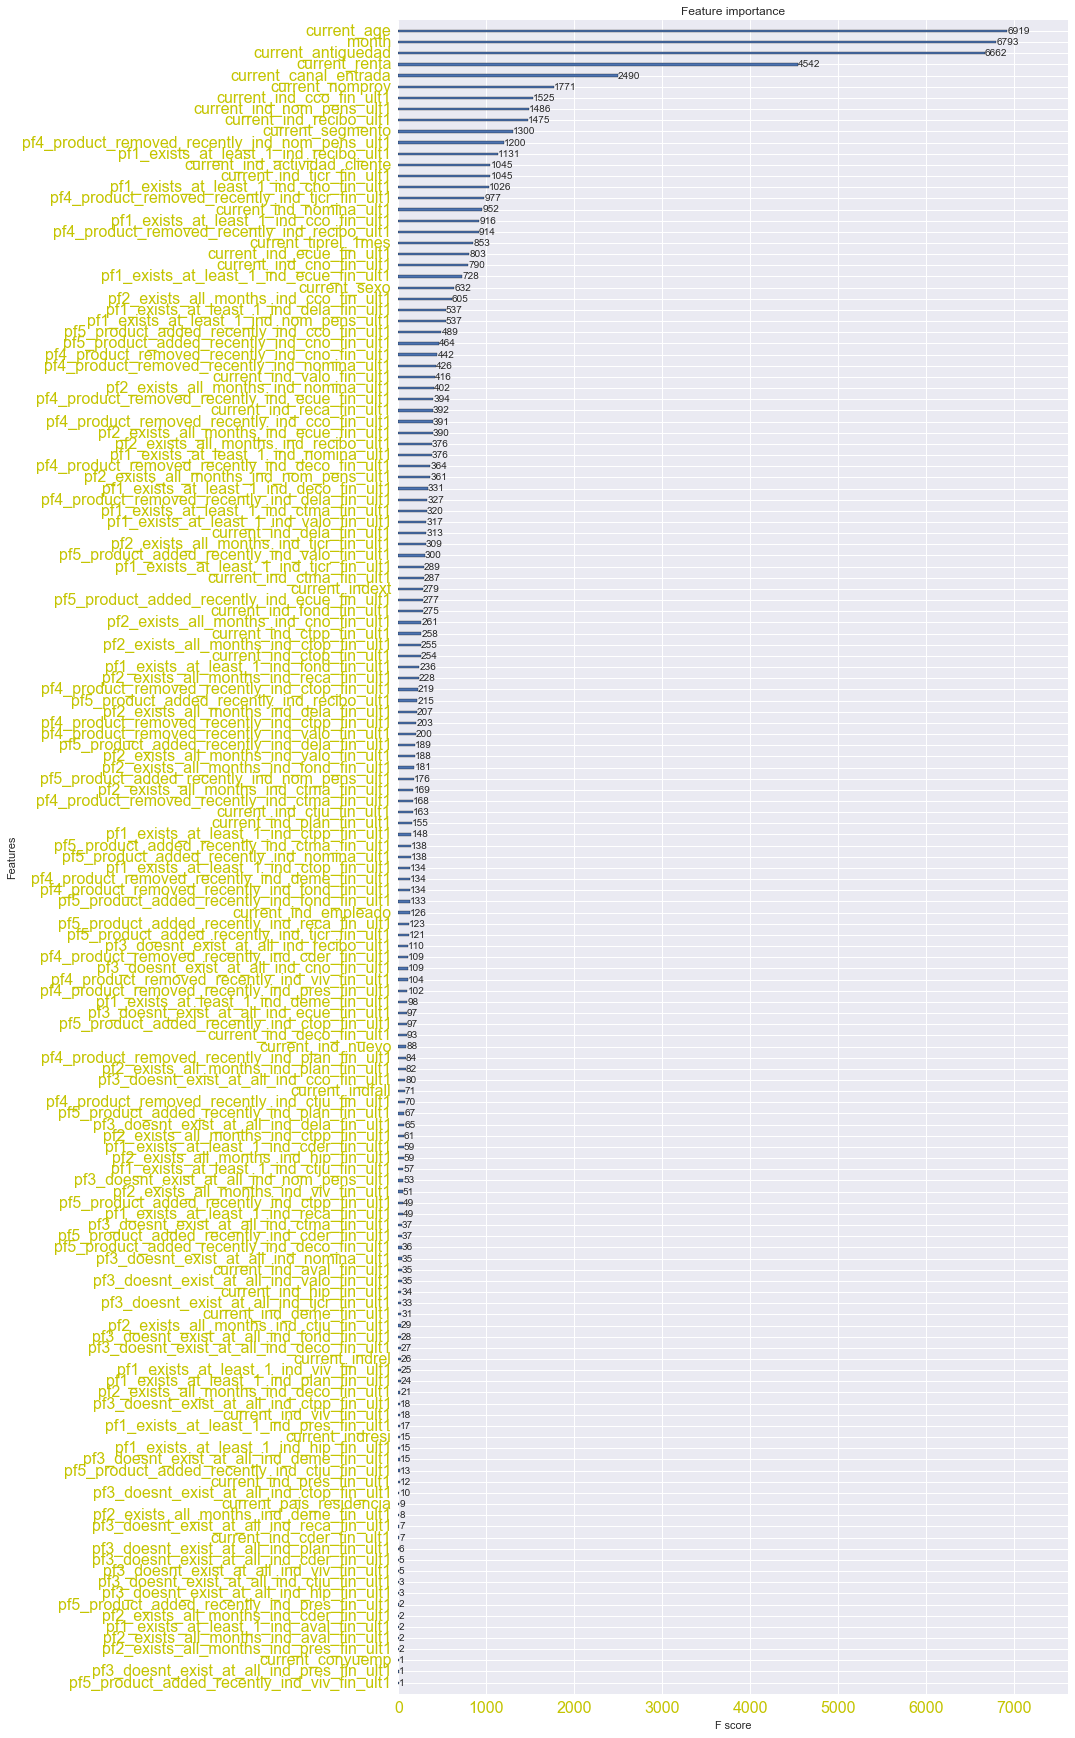

time: 4.53 s


In [90]:
pylab.rcParams['figure.figsize'] = (12, 30)
xgb.plot_importance(xgb_model)
# plt.xticks(rotation=90)
plt.tick_params(labelsize=16, labelcolor="#c4c400")
# plt.ylabel("Median Income", size=32, color="#ffc400")
# plt.xlabel("City", size=32, color="#ffc400")
# plt.title("Income Distribution by City", size=40, color="#ffc400")
# plt.ylim(0, 200000)
# plt.yticks(range(0, 200000, 40000))

In [91]:
pickle_description = '9. Contains test_ver2.ncodpers, and its respective preds, and label_encoder'
test_ncodpers = list(test.index)
dump_object = (pickle_description, test_ncodpers, preds, label_encoder)

pickle.dump(dump_object, open(filename+'.pickle', 'wb'))

time: 27.8 s


In [117]:
evals_iters = [0.760737, 0.760112, 0.762351, 0.764525, 0.764862, 0.765021, 0.765182, 0.765401, 0.765664, 0.765947, 0.766026, 0.766244, 0.766318, 0.766633, 0.766739, 0.766998, 0.767179, 0.767416, 0.767661, 0.767776, 0.767896, 0.768177, 0.76839, 0.768641, 0.768746, 0.768938, 0.769115, 0.769253, 0.769432, 0.769592, 0.769758, 0.769955, 0.770034, 0.770231, 0.770355, 0.770487, 0.770586, 0.770695, 0.770767, 0.770899, 0.770987, 0.7711, 0.771182, 0.771309, 0.771447, 0.771521, 0.77161, 0.771743, 0.771807, 0.771895, 0.772033, 0.772097, 0.772151, 0.772246, 0.772359, 0.772466, 0.772606, 0.772701, 0.772792, 0.772871, 0.772948, 0.773039, 0.773152, 0.773245, 0.773319, 0.773408, 0.773471, 0.77355, 0.773648, 0.773738, 0.773808, 0.773847, 0.773935, 0.773976, 0.774028, 0.774085, 0.77415, 0.774216, 0.774232, 0.774284, 0.774345, 0.774402, 0.774456, 0.774513, 0.774589, 0.774644, 0.774687, 0.774721, 0.774766, 0.774793, 0.77483, 0.774886, 0.774947, 0.774988, 0.774993, 0.775051, 0.775083, 0.775126, 0.775199, 0.775248]

time: 4.17 ms


In [123]:
eval_pd = pd.DataFrame()
eval_pd['map7_eval_score'] = pd.Series(evals_iters)
eval_pd.reset_index(inplace=True)

time: 11.3 ms


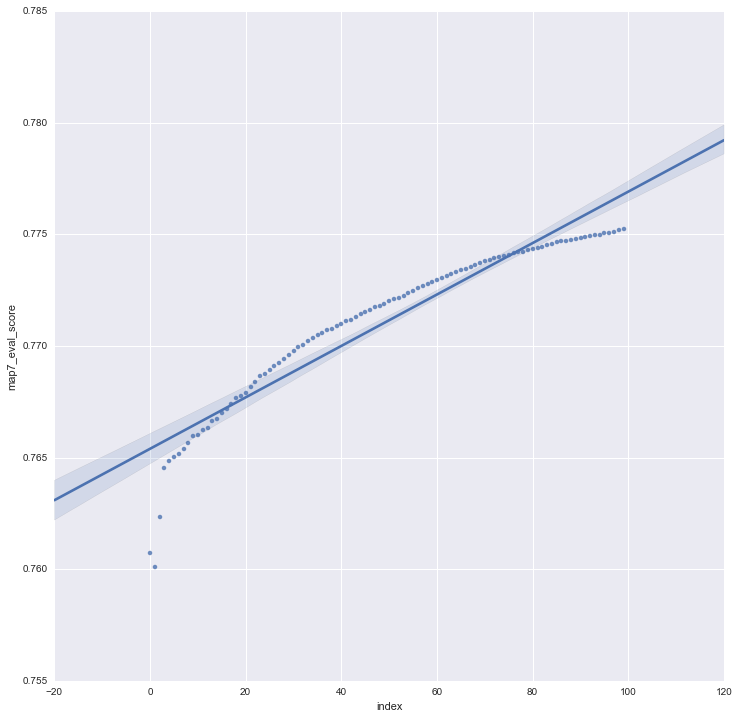

time: 691 ms


In [129]:
pylab.rcParams['figure.figsize'] = (12, 12)
sns.regplot(x='index', y='map7_eval_score', data = eval_pd)

In [139]:
initial_base = xgb_main.get_base_margin()
ptrain = xgb_model.predict(xgb_main, output_margin=True)
xgb_main.set_base_margin(ptrain)

TypeError: only length-1 arrays can be converted to Python scalars

time: 367 ms


In [140]:
xgb_main.set_base_margin?

time: 4.49 ms
